#### We import Pyspark and its SQL library.

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

#### We read the departure and schedule files which are json filed. Though zipped, Hadoop is smart and will recognize it and does open it so there is no need to extract the files. Then We transform the above files into rdd in order to clean our data.

In [2]:
dfDepartureRdd = sqlContext.read.json ("Departure/").rdd
dfScheduleRdd = sqlContext.read.json("schedule/").rdd

#### We define the following function in order to get the features that we need in order to join departure and schedule data. We need origin Airport, flight Id, actual departure timestamp and the day of flight from the departure data which gives rise to the following function. Note that we use try and except in order to avoid possible errors in extracting the desired features.

In [3]:
def f(x):
    try:
        return (x["payload"]["originAirport"]["code"],x["payload"]["flightAwareFlightId"], \
                x["payload"]["actualDepartureTimestamp"],int(str(x['dt'])[-2:]))
    except Exception as e:
        return (0,0,0,0)

#### Similarly we use the following function to take the origin Airport, flight Id and official departure time from the schedule time.

In [4]:
def g(x):
    try:
        return (x["originAirport"]["code"],x["flightAwareFlightId"],x["filedDepartureTime"])
    except Exception as e:
        return (0,0,0)

#### We map the dfDepartureRdd and dfScheduleRdd using the above functions therefore the data will look better and then We make dataframes by the above rdds.

In [5]:
dfDepartureCleaned = dfDepartureRdd.map(lambda x: f(x)). \
                     toDF(schema=["originAirport","flightID", "actualDepartureTime","day"])
dfScheduleCleaned = dfScheduleRdd.map(lambda x: g(x)). \
                     toDF(schema=["originAirport","flightID", "filedDepartureTime"])

In [6]:
dfDepartureCleaned.createOrReplaceTempView("departuredCleaned")
dfScheduleCleaned.createOrReplaceTempView("scheduledCleaned")

#### In the following sql query in Pysparksql, we join the dataframes of departuredCleaned and scheduledCleaned on flight ids and origin flights (Note that the origin flight for the schedule file is KDCA) and then find the distinc rows and then take the rows whose difference of actualdeparturetime and filedDepartureTime is bigger than zero as they will be called delayed flights. For the sake of simplicty, we divide the time difference by 3600000 to get the delay times for each flight at the airport KCDA in hours and finally we take the average of delays by grouping the flights by day and we round the average by 2 to get a better readable result.

In [7]:
avgDelayforDay = sqlContext.sql("SELECT round(AVG(delayTimeInHour),2) AS avgDelayTimeInHour, day FROM \
                      (SELECT (actualDepartureTime - filedDepartureTime)/3600000 AS delayTimeInHour, day FROM \
                      (SELECT DISTINCT * FROM(SELECT a.actualDepartureTime, b.filedDepartureTime, a.day \
                      FROM departuredCleaned a FULL OUTER JOIN scheduledCleaned b \
                     on (a.flightID = b.flightID AND a.originAirport = b.originAirport) WHERE \
                     a.flightID IS NOT null))) WHERE (day >0 AND delayTimeInHour >0) GROUP BY day ORDER BY day ASC")

#### We are done calculating the day, delay dataframe. It is time to convert the data to pandas to do statistiacal classification.

In [8]:
avgDelayforDayPandas = avgDelayforDay.toPandas()
avgDelayforDayPandas.head()
avgDelayforDayPandas.describe()

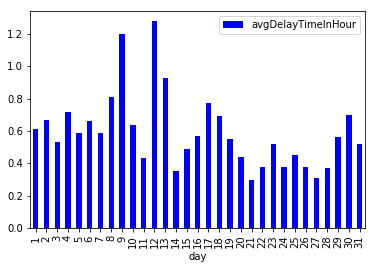

In [9]:
avgDelayforDayPandas.plot.bar(x = 'day', y = 'avgDelayTimeInHour',color = 'blue')

#### Note that the average dalay on ninth and 12th day are very different from the rest of data therefore, we use the median of average daily delays as our threshold.
#### We define the threshold function which will be applied to our pandas data frame avgDelayforDayPandas.

In [10]:
def binaryMapper(threshold, x):
    if x >= threshold:
        return 1
    else:
        return 0

#### We import the libraries that we will use.

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score
import scikitplot as skplt

#### In the following command we measure the performance of Logistic Regression, Stochastic Classifier and Random Forest Classifier and show that Random Forest and Logisitc Regression do better than Stochastic Gradient Descent but Random forest is the best based on its ROC curve.

Confusion Matrix for Logisitc Regression is:
[[5 0]
 [2 0]]
Confusion Matrix for Stochastic Gradient Descent is:
[[0 5]
 [0 2]]
Confusion Matrix for Random Forest Classifier is:
[[5 0]
 [2 0]]
Accuracy Score for Logistic Regression for the last 7 days of January is:
0.7142857142857143
Accuracy Score for SGDClassifier for the last 7 days of January is:
0.2857142857142857
Accuracy Score for Random Forest Classifier for the last 7 days of January is:
0.7142857142857143


ROC curve of Logistic Regression Model is :


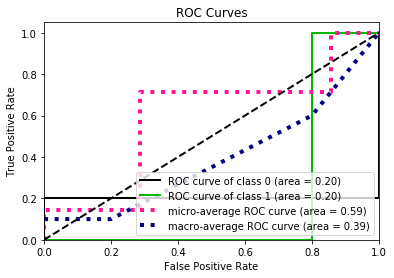

ROC curve of Random Forest Classifier is :


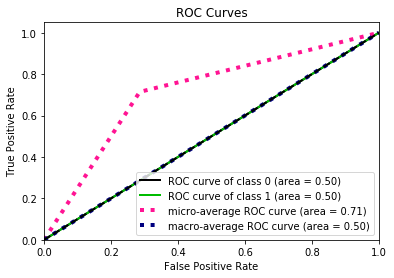

In [25]:
X = avgDelayforDayPandas
threshold = 0.56
# We make a new column to have just zero and 1 based on the threshold we define.
X["New"] = X["avgDelayTimeInHour"].apply(lambda x: binaryMapper(threshold,x))
X = X.drop(columns=["avgDelayTimeInHour"])
X_train = np.asarray(X.iloc[:24,0])
X_test = np.asarray(X.iloc[24:,0])
y_train = np.asarray(X.iloc[:24,1])
y_test = np.asarray(X.iloc[24:,1])
# clf stands for the logistic regression.
# sgd_clf stands for Stochastic Gradient Descent Classifier.
# forest_clf stands for Random Forest Classifer.
clf = LogisticRegression(random_state= 42).fit(X_train.reshape(-1, 1), y_train)
sgd_clf = SGDClassifier(random_state=42).fit(X_train.reshape(-1, 1), y_train)
forest_clf = RandomForestClassifier(random_state=42).fit(X_train.reshape(-1, 1), y_train)
y_predict = clf.predict(X_test.reshape(-1, 1))
conf_mx =  confusion_matrix(y_test, y_predict)
y_predictSGD = sgd_clf.predict(X_test.reshape(-1,1))
conf_mxSGD =  confusion_matrix(y_test, y_predictSGD)
y_predictforest = forest_clf.predict(X_test.reshape(-1,1))
conf_mxforest =  confusion_matrix(y_test, y_predictforest)
print "Confusion Matrix for Logisitc Regression is:"
print conf_mx
print "Confusion Matrix for Stochastic Gradient Descent is:"
print conf_mxSGD
print "Confusion Matrix for Random Forest Classifier is:"
print conf_mxforest
logisitic_regression_prob = clf.predict_proba(X_test.reshape(-1,1))
random_forest_classifier_prob = forest_clf.predict_proba(X_test.reshape(-1,1))
print "Accuracy Score for Logistic Regression for the last 7 days of January is:"
print accuracy_score(y_test, y_predict)
print "Accuracy Score for SGDClassifier for the last 7 days of January is:" 
print accuracy_score(y_test,y_predictSGD)
print "Accuracy Score for Random Forest Classifier for the last 7 days of January is:" 
print accuracy_score(y_test,y_predictforest)
print "\n"
print "ROC curve of Logistic Regression Model is :"
skplt.metrics.plot_roc(y_test, logisitic_regression_prob)
plt.show()
print "ROC curve of Random Forest Classifier is :"
skplt.metrics.plot_roc(y_test, random_forest_classifier_prob)
plt.show()

#### The Accuracy scores are based on the confusion matrices of the corresponding classifiers. Which is (TP + TN)/(TP +TN +FP + FN). Therefore the accuracy of random forest classifier and logisitc regressin are equal to 5/7 = 0.71 and the accuracy of stochastic gradient descent classifier is 2/7 = 0.28.

#### Since the accuracy of random forest and logisitc regression are equal and is way better than stachastic gradient descent classifier's accuracy, therefore they are better candidates. On the other hand, the ROC performance of Random forest is better than that of Logisitc Regression as the ROC curves are closer to top-left therefore we use Random Forest Classifier as our model.

In [26]:
print random_forest_classifier_prob

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


#### The probability of having delay on the next 7 days is zero on each day.

#### On the last section of this excercise, we rank the top 10 Airports by Departing flights for the 30 days.

In [32]:
sqlContext.sql("SELECT COUNT(originAirport) AS numberofDeps, originAirport FROM \
                                 departuredCleaned GROUP BY originAirport ORDER BY numberofDeps DESC LIMIT 10").show()

+------------+-------------+
|numberofDeps|originAirport|
+------------+-------------+
|       35057|         KATL|
|       34900|         KORD|
|       28825|         KLAX|
|       26872|         KDFW|
|       24543|         ZBAA|
|       23669|         KDEN|
|       23426|         CYYZ|
|       20946|         KCLT|
|       19910|         ZSPD|
|       18893|         KSFO|
+------------+-------------+



#### The top 10 airports by most departing flights for the first 30 days of January 2018 are: KATL, KORD, KLAX, KDFW,ZBAA, KDEN, CYYZ, KCLT, ZSPD, KSFO
